<img src="https://certificate.tpq.io/taim_logo.png" width="350px" align="right">

# Artificial Intelligence in Finance

## Recurrent Neural Networks

Dr Yves J Hilpisch | The AI Machine

http://aimachine.io | http://twitter.com/dyjh

## First Example

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from pprint import pprint
from pylab import plt, mpl
plt.style.use('seaborn-v0_8')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
pd.set_option('display.precision', 4)
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'

In [3]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seeds()

In [4]:
a = np.arange(100)
a

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [5]:
a = a.reshape((len(a), -1))

In [6]:
a.shape

(100, 1)

In [7]:
a[:5]

array([[0],
       [1],
       [2],
       [3],
       [4]])

In [8]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [9]:
lags = 3

In [10]:
g = TimeseriesGenerator(a, a, length=lags, batch_size=5)

In [11]:
pprint(list(g)[0])

(array([[[0],
        [1],
        [2]],

       [[1],
        [2],
        [3]],

       [[2],
        [3],
        [4]],

       [[3],
        [4],
        [5]],

       [[4],
        [5],
        [6]]]),
 array([[3],
       [4],
       [5],
       [6],
       [7]]))


In [12]:
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense

In [13]:
model = Sequential()
model.add(SimpleRNN(100, activation='relu',
                    input_shape=(lags, 1)))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adagrad', loss='mse',
              metrics=['mae'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100)               10200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [15]:
%%time
model.fit(g, epochs=1000, steps_per_epoch=5,
            verbose=False)

CPU times: user 10.5 s, sys: 1.02 s, total: 11.5 s
Wall time: 9.94 s


In [16]:
res = pd.DataFrame(model.history.history)

In [17]:
res.tail(3)

,loss,mae
997,1.1002,0.9686
998,1.1798,0.9570
999,0.3098,0.5181


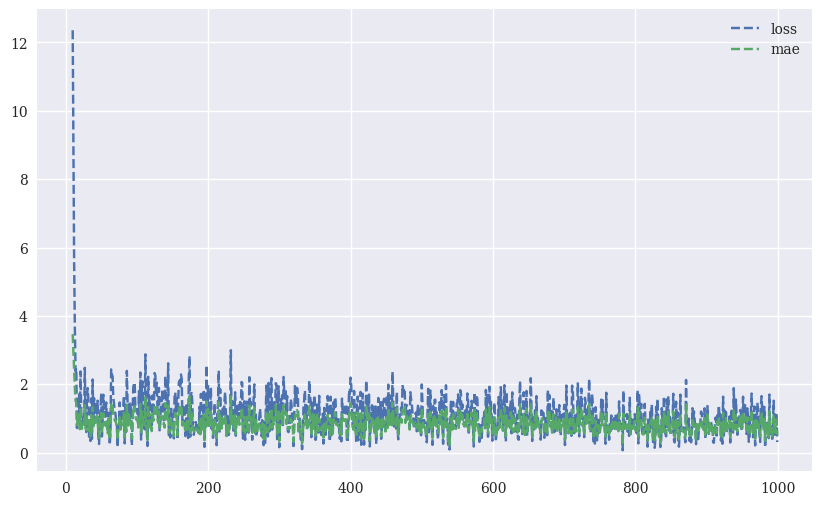

In [18]:
res.iloc[10:].plot(figsize=(10, 6), style=['--', '--']);

In [19]:
x = np.array([21, 22, 23]).reshape((1, lags, 1))
y = model.predict(x, verbose=False)
int(round(y[0, 0]))

23

In [20]:
x = np.array([87, 88, 89]).reshape((1, lags, 1))
y = model.predict(x, verbose=False)
int(round(y[0, 0]))

91

In [21]:
x = np.array([187, 188, 189]).reshape((1, lags, 1))
y = model.predict(x, verbose=False)
int(round(y[0, 0]))

193

In [22]:
x = np.array([1187, 1188, 1189]).reshape((1, lags, 1))
y = model.predict(x, verbose=False)
int(round(y[0, 0]))

1220

## Second Example

In [23]:
def transform(x):
    y = 0.05 * x ** 2 + 0.2 * x + np.sin(x) + 5
    y += np.random.standard_normal(len(x)) * 0.2
    return y

In [24]:
x = np.linspace(-2 * np.pi, 2 * np.pi, 500)
a = transform(x)

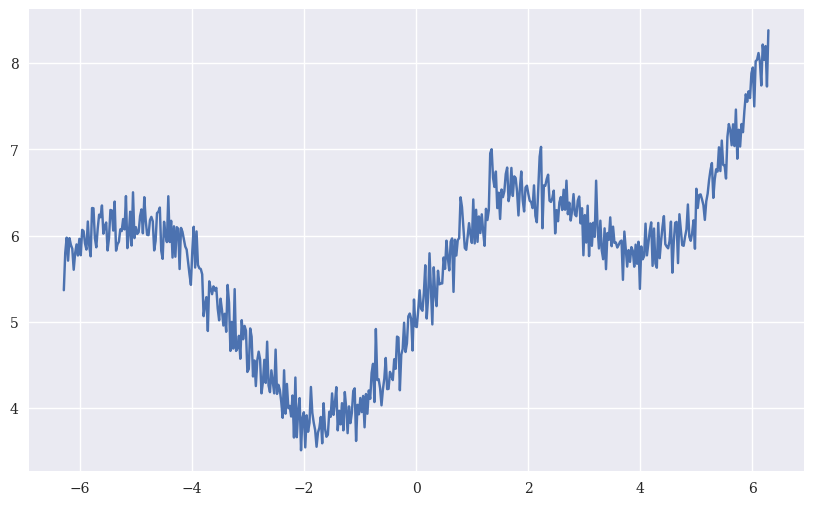

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(x, a);

In [26]:
a = a.reshape((len(a), -1))

In [27]:
a[:5]

array([[5.3673],
       [5.8002],
       [5.9768],
       [5.7102],
       [5.9715]])

In [28]:
lags = 5

In [29]:
g = TimeseriesGenerator(a, a, length=lags, batch_size=5)

In [30]:
model = Sequential()
model.add(SimpleRNN(500, activation='relu', input_shape=(lags, 1)))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 500)               251000    
                                                                 
 dense_1 (Dense)             (None, 1)                 501       
                                                                 
Total params: 251,501
Trainable params: 251,501
Non-trainable params: 0
_________________________________________________________________


In [32]:
%%time
model.fit(g, epochs=500,
          steps_per_epoch=10,
          verbose=False)

CPU times: user 31.2 s, sys: 12.2 s, total: 43.5 s
Wall time: 20.9 s


In [33]:
x = np.linspace(-6 * np.pi, 6 * np.pi, 1000)
d = transform(x)

In [34]:
g_ = TimeseriesGenerator(d, d, length=lags, batch_size=len(d))

In [35]:
f = list(g_)[0][0].reshape((len(d) - lags, lags, 1))

In [36]:
y = model.predict(f, verbose=False)

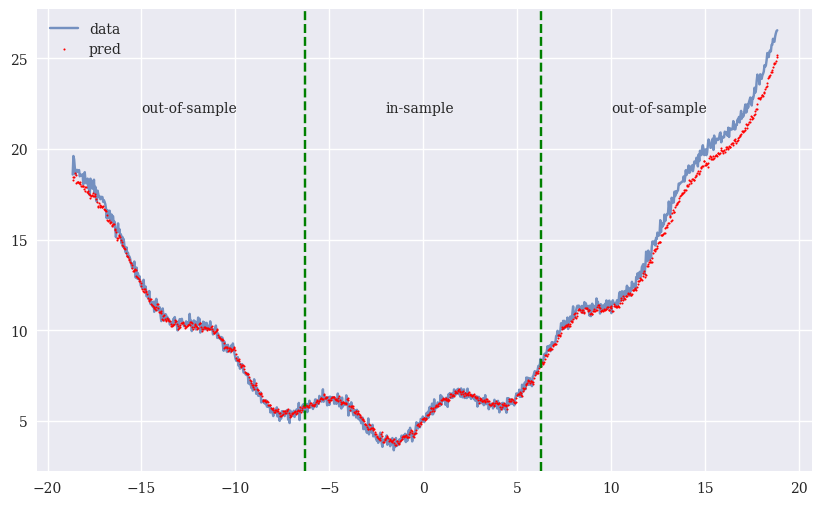

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(x[lags:], d[lags:], label='data', alpha=0.75)
plt.plot(x[lags:], y, 'r.', label='pred', ms=3)
plt.axvline(-2 * np.pi, c='g', ls='--')
plt.axvline(2 * np.pi, c='g', ls='--')
plt.text(-15, 22, 'out-of-sample')
plt.text(-2, 22, 'in-sample')
plt.text(10, 22, 'out-of-sample')
plt.legend();

## Financial Price Series

In [38]:
url = 'http://hilpisch.com/aiif_eikon_id_eur_usd.csv'

In [39]:
symbol = 'EUR_USD'

In [40]:
raw = pd.read_csv(url, index_col=0, parse_dates=True)

In [41]:
def generate_data():
    data = pd.DataFrame(raw['CLOSE'])
    data.columns = [symbol]
    data = data.resample('30min', label='right').last().ffill()
    return data

In [42]:
data = generate_data()

In [43]:
data = (data - data.mean()) / data.std()

In [44]:
p = data[symbol].values

In [45]:
p = p.reshape((len(p), -1))

In [46]:
lags = 5

In [47]:
g = TimeseriesGenerator(p, p, length=lags, batch_size=5)

In [48]:
def create_rnn_model(hu=100, lags=lags, layer='SimpleRNN',
                           features=1, algorithm='estimation'):
    model = Sequential()
    if layer == 'SimpleRNN':
        model.add(SimpleRNN(hu, activation='relu',
                            input_shape=(lags, features)))
    else:
        model.add(LSTM(hu, activation='relu',
                       input_shape=(lags, features)))
    if algorithm == 'estimation':
        model.add(Dense(1, activation='linear'))
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    else:
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy',
                      metrics=['accuracy'])
    return model

In [49]:
model = create_rnn_model()

In [50]:
%%time
model.fit(g, epochs=500, steps_per_epoch=10,
          verbose=False)

CPU times: user 8.12 s, sys: 686 ms, total: 8.8 s
Wall time: 7.31 s


In [51]:
y = model.predict(g, verbose=False)

In [52]:
data['pred'] = np.nan
data['pred'].iloc[lags:] = y.flatten()

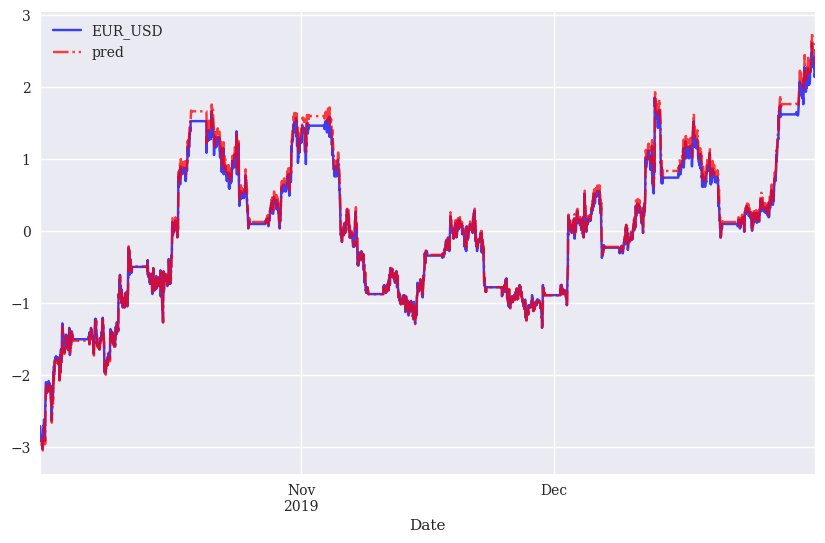

In [53]:
data[[symbol, 'pred']].plot(
            figsize=(10, 6), style=['b', 'r-.'],
            alpha=0.75);

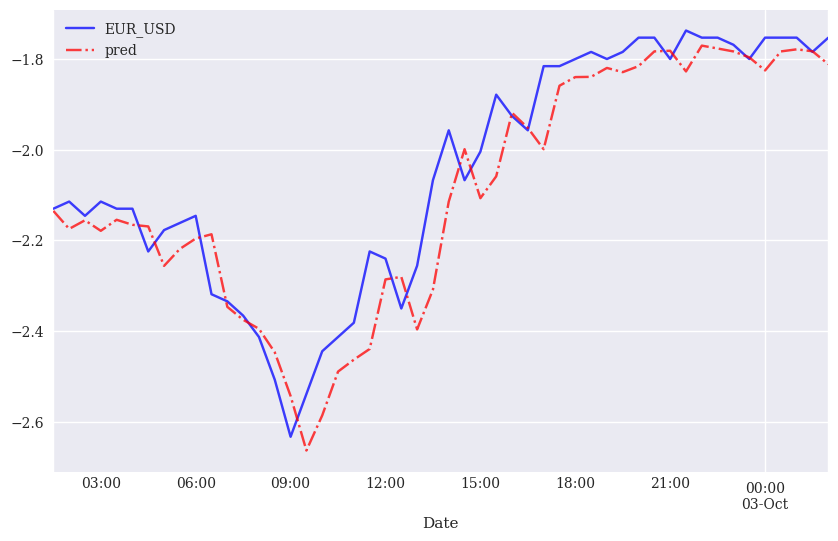

In [54]:
data[[symbol, 'pred']].iloc[50:100].plot(
            figsize=(10, 6), style=['b', 'r-.'],
            alpha=0.75);

## Financial Return Series 

In [55]:
data = generate_data()

In [56]:
data['r'] = np.log(data / data.shift(1))

In [57]:
data.dropna(inplace=True)

In [58]:
data = (data - data.mean()) / data.std()

In [59]:
r = data['r'].values

In [60]:
r = r.reshape((len(r), -1))

In [61]:
g = TimeseriesGenerator(r, r, length=lags, batch_size=5)

In [62]:
# list(g)[0]

In [63]:
model = create_rnn_model()

In [64]:
%%time
model.fit(g, epochs=500, steps_per_epoch=10,
          verbose=False)

CPU times: user 8.09 s, sys: 702 ms, total: 8.79 s
Wall time: 7.3 s


In [65]:
y = model.predict(g, verbose=False)

In [66]:
data['pred'] = np.nan
data['pred'].iloc[lags:] = y.flatten()
data.dropna(inplace=True)

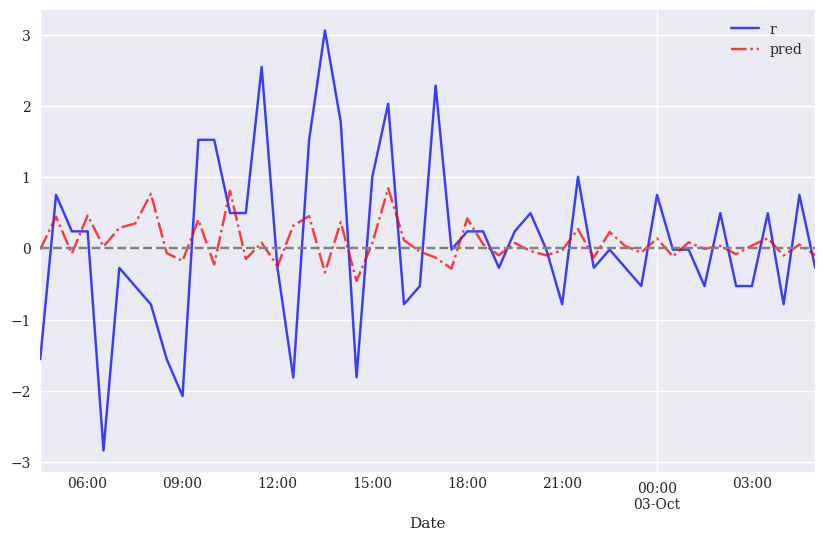

In [67]:
data[['r', 'pred']].iloc[50:100].plot(
            figsize=(10, 6), style=['b', 'r-.'],
            alpha=0.75);
plt.axhline(0, c='grey', ls='--');

In [68]:
from sklearn.metrics import accuracy_score

In [69]:
accuracy_score(np.sign(data['r']), np.sign(data['pred']))

0.6663642549330914

In [70]:
split = int(len(r) * 0.8)

In [71]:
train = r[:split]

In [72]:
test = r[split:]

In [73]:
g = TimeseriesGenerator(train, train, length=lags, batch_size=5)

In [74]:
set_seeds()
model = create_rnn_model(hu=100)

In [75]:
%%time
model.fit(g, epochs=100, steps_per_epoch=10, verbose=False)

CPU times: user 1.98 s, sys: 188 ms, total: 2.17 s
Wall time: 1.79 s


In [76]:
g_ = TimeseriesGenerator(test, test, length=lags, batch_size=5)

In [77]:
y = model.predict(g_)

176/176 [==============================] - 0s 444us/step


In [78]:
accuracy_score(np.sign(test[lags:]), np.sign(y))

0.6753986332574032

## Financial Features

In [79]:
data = generate_data()

In [80]:
data['r'] = np.log(data / data.shift(1))

In [81]:
window = 20
data['mom'] = data['r'].rolling(window).mean()
data['vol'] = data['r'].rolling(window).std()

In [82]:
data.dropna(inplace=True)

### Estimation

In [83]:
split = int(len(data) * 0.8)

In [84]:
train = data.iloc[:split].copy()

In [85]:
mu, std = train.mean(), train.std()

In [86]:
train = (train - mu) / std

In [87]:
test = data.iloc[split:].copy()

In [88]:
test = (test - mu) / std

In [89]:
g = TimeseriesGenerator(train.values, train['r'].values,
                        length=lags, batch_size=5)

In [90]:
set_seeds()
model = create_rnn_model(hu=100, features=len(data.columns),
                         layer='SimpleRNN')

In [91]:
%%time
model.fit(g, epochs=100, steps_per_epoch=10,
                verbose=False)

CPU times: user 1.95 s, sys: 190 ms, total: 2.14 s
Wall time: 1.75 s


In [92]:
g_ = TimeseriesGenerator(test.values, test['r'].values,
                         length=lags, batch_size=5)

In [93]:
y = model.predict(g_).flatten()

175/175 [==============================] - 0s 464us/step


In [94]:
accuracy_score(np.sign(test['r'].iloc[lags:]), np.sign(y))

0.6739130434782609

### Classification

In [95]:
set_seeds()
model = create_rnn_model(hu=50,
            features=len(data.columns),
            layer='LSTM',
            algorithm='classification')

In [96]:
train_y = np.where(train['r'] > 0, 1, 0)

In [97]:
np.bincount(train_y)

array([2374, 1142])

In [98]:
def cw(a):
    c0, c1 = np.bincount(a)
    w0 = (1 / c0) * (len(a)) / 2
    w1 = (1 / c1) * (len(a)) / 2
    return {0: w0, 1: w1}

In [99]:
g = TimeseriesGenerator(train.values, train_y,
                        length=lags, batch_size=5)

In [100]:
%%time
model.fit(g, epochs=5, steps_per_epoch=10,
          verbose=False, class_weight=cw(train_y))

CPU times: user 633 ms, sys: 75.7 ms, total: 709 ms
Wall time: 556 ms


In [101]:
test_y = np.where(test['r'] > 0, 1, 0)

In [102]:
g_ = TimeseriesGenerator(test.values, test_y,
                         length=lags, batch_size=5)

In [103]:
y = np.where(model.predict(g_, batch_size=None) > 0.5,
             1, 0).flatten()

175/175 [==============================] - 0s 475us/step


In [104]:
np.bincount(y)

array([534, 340])

In [105]:
accuracy_score(test_y[lags:], y)

0.6086956521739131

### Deep RNNs

In [106]:
from keras.layers import Dropout

In [107]:
def create_deep_rnn_model(hl=2, hu=100, layer='SimpleRNN',
                          optimizer='rmsprop', features=1,
                          dropout=False, rate=0.3, seed=100):
    if hl <= 2: hl = 2
    if layer == 'SimpleRNN':
        layer = SimpleRNN
    else:
        layer = LSTM
    model = Sequential()
    model.add(layer(hu, input_shape=(lags, features),
                     return_sequences=True,
                    ))
    if dropout:
        model.add(Dropout(rate, seed=seed))
    for _ in range(2, hl):
        model.add(layer(hu, return_sequences=True))
        if dropout:
            model.add(Dropout(rate, seed=seed))
    model.add(layer(hu))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [108]:
set_seeds()
model = create_deep_rnn_model(
            hl=2, hu=50, layer='SimpleRNN',
            features=len(data.columns),
            dropout=True, rate=0.3)

In [109]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 5, 50)             2750      
                                                                 
 dropout (Dropout)           (None, 5, 50)             0         
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 7,851
Trainable params: 7,851
Non-trainable params: 0
_________________________________________________________________


In [110]:
%%time
model.fit(g, epochs=200, steps_per_epoch=10,
          verbose=False, class_weight=cw(train_y))

CPU times: user 5.19 s, sys: 586 ms, total: 5.78 s
Wall time: 4.46 s


In [111]:
y = np.where(model.predict(g_, batch_size=None) > 0.5,
             1, 0).flatten()

175/175 [==============================] - 0s 531us/step


In [112]:
np.bincount(y)

array([419, 455])

In [113]:
accuracy_score(test_y[lags:], y)

0.5869565217391305

<img src='http://hilpisch.com/taim_logo.png' width="350px" align="right">

<br><br><br><a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:ai@tpq.io">ai@tpq.io</a>